In [1]:
def calculate_scoring_rates(pbp_data, time_interval=60, period_len=600):
    if period_len % time_interval != 0:
        raise ValueError('Period length must be divisible by rate')

    pbp_data['interval'] = pbp_data['elapsed_time'].floordiv(time_interval)
    pbp_data = pbp_data.set_index(['fixture_id', 'period', 'interval'])
    pbp_grouped = pbp_data.groupby(level=pbp_data.index.names)['points_a_chg', 'points_h_chg'].sum()
    pbp_grouped.columns = ['points_a', 'points_h']
    pbp_grouped['points_dif'], pbp_grouped['points_tot'] = pbp_grouped['points_h'] - pbp_grouped['points_a'], \
                                                           pbp_grouped['points_h'] + pbp_grouped['points_a']

    ref_data = pbp_data[['team_a', 'team_h']]
    ref_data = ref_data.groupby(level=ref_data.index.names).first()
    pbp_grouped = pbp_grouped.merge(ref_data, how='left', left_index=True, right_index=True)
    return pbp_grouped

def variance_ratio_test(base_time_interval=15, eval_time_intervals=None, period_len=600):
    if period_len % base_time_interval != 0:
        raise ValueError('Period length must be divisible by base rate')

    if eval_time_intervals is None:
        eval_time_intervals = [30, 60, 90, 120, 180, 240]
    for eval_time_interval in eval_time_intervals:
        if period_len % eval_time_interval:
            raise ValueError('Period length must be divisible by all evaluation times')

    def calculate_variance_ratio(base_var, test_var, test_time_interval):
        q = test_time_interval / base_time_interval
        vr = test_var / (base_var * q)
        return vr

    base_sr_df = calculate_scoring_rates(time_interval=base_time_interval)
    base_pts_dif_var = np.var(base_sr_df['points_dif'])
    base_pts_tot_var = np.var(base_sr_df['points_tot'])

    vr_stats = []
    for cur_ti in tqdm(eval_time_intervals):
        cur_sr_df = calculate_scoring_rates(time_interval=cur_ti)
        cur_pts_dif_vr = calculate_variance_ratio(base_pts_dif_var, np.var(cur_sr_df['points_dif']), cur_ti)
        cur_pts_tot_vr = calculate_variance_ratio(base_pts_tot_var, np.var(cur_sr_df['points_tot']), cur_ti)
        vr_stats.extend([{'time_interval': cur_ti, 'variance_ratio': cur_pts_dif_vr, 'on': 'pts_diff'},
                        {'time_interval': cur_ti, 'variance_ratio': cur_pts_tot_vr, 'on': 'pts_total'}])

    vr_stats_df = pd.DataFrame(vr_stats)
    return vr_stats_df

In [527]:
import numpy as np
import pandas as pd
import pylab as P
from arch.unitroot import VarianceRatio
from nolds import hurst_rs
import warnings
from stockstats import StockDataFrame
from sgmrsm.factor_model.basketball.play_by_play_data import PlayByPlayCleanData
from IPython.display import display, clear_output

%matplotlib inline

In [10]:
pbp_data = PlayByPlayCleanData('2016-10-01', '2016-12-01', 'NBA', 'pbp', use_cache=True).get_data_ready()
clear_output()

In [585]:
def process_data(pbp_data, comp, time_interval=15., hl=10):
    cols = ['fixture_id', 'clock', 'period', 'points_h', 'points_a']
    target_cols = ['points_h', 'points_a']
    df = pbp_data.reset_index().loc[:, cols]
    fix_ids = list(set(df.fixture_id))
    if 'Q1' in df.period.values:
        df.loc[:, 'period'] = df.period.map(lambda x: int(x[1:]) - 1)
    normal_period_len = 720. if comp == 'NBA' else 600.
    ot_period_len = 300.
    df.loc[:, 'elapsed_time'] = np.where(df.period > 3, ot_period_len, normal_period_len) - df.clock
    df.loc[:, 'elapsed_time'] += np.minimum(df.period, 4) * normal_period_len + \
                                 np.maximum(df.period - 4, 0) * ot_period_len
    df = df.sort_values('elapsed_time')
    
    df['interval'] = df['elapsed_time'].floordiv(time_interval).astype(int) + 1   
    df_g = df.groupby(['fixture_id', 'interval'])[target_cols].max()
    expand_idx = [(fid, ival) 
                  for fid, d in df_g.groupby(level='fixture_id') 
                  for ival in range(int(max(d.index.get_level_values('interval')) + 1))]
    df_g = df_g.loc[expand_idx, :]
    df_g.loc[pd.IndexSlice[:, 0], target_cols] = 0
    df_g.loc[:, target_cols] = df_g.loc[:, target_cols].fillna(method='ffill')
    df_g = df_g.reset_index()

    df_g.loc[:, 'points_diff'] = df_g.points_h - df_g.points_a
    df_g.loc[:, 'points_tot'] = df_g.points_h + df_g.points_a
    target_cols += ['points_diff', 'points_tot']

    delta_cols = []
    for col in target_cols:
        delta_col = col.replace('points', 'points_delta')
        df_g.loc[:, delta_col] = (df_g[col] - df_g[col].shift(1).fillna(0))
        df_g.loc[df_g.interval == 0, delta_col] = 0
        delta_cols.append(delta_col)
    
    df_g.loc[:, 'interval_time'] = time_interval * df_g.interval

    info_cols = ['fixture_id', 'team_a', 'team_h']
    ref_df = pbp_data.reset_index().loc[:, info_cols]
    ref_df = ref_df.drop_duplicates()
    df_g = df_g.merge(ref_df, how='left').sort_values(['fixture_id', 'interval'])
    
    def ewma_rate(s):
        return s.ewm(halflife=hl).mean() / time_interval
    for col in delta_cols:
        rate_col = col.replace('points_delta', 'rate')
        df_g.loc[:, rate_col] = df_g.groupby('fixture_id')[col].apply(ewma_rate)
    
    return df_g

In [524]:
def vr_test(s, lag):
    if len(s) < 2 * lag:
        return np.nan
    vr = VarianceRatio(s, lag)
    return vr.stat

def mk_test(x, out='both'):
    """
    This function is derived from code originally posted by Sat Kumar Tomer (satkumartomer at gmail.com)
    See also: http://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm

    The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert 1987) is to statistically assess if there is a monotonic upward or downward trend of the variable of interest over time. A monotonic upward (downward) trend means that the variable consistently increases (decreases) through time, but the trend may or may not be linear. The MK test can be used in place of a parametric linear regression analysis, which can be used to test if the slope of the estimated linear regression line is different from zero. The regression analysis requires that the residuals from the fitted regression line be normally distributed; an assumption not required by the MK test, that is, the MK test is a non-parametric (distribution-free) test.
    Hirsch, Slack and Smith (1982, page 107) indicate that the MK test is best viewed as an exploratory analysis and is most appropriately used to identify stations where changes are significant or of large magnitude and to quantify these findings.

    Input:
        x:   a vector of data
    Output:
        p: p value of the significance test
        z: normalized test statistics

    Examples
    --------
      >>> x = np.random.rand(100)
      >>> p, z = mk_test(x, 0.05)
    """    
    n = len(x)

    # Calculate S
    s = 0
    for k in range(n-1):
        s += np.sign(x[(k + 1):] - x[k]).sum()
    
    # Calculate var(S)
    var_s = float(n * (n - 1) * (2 * n + 5)) / 18
    g = len(np.unique(x))
    if g < n:
        x2 = sorted(x)
        for xx, xg in groupby(x2):
            tp = len(list(xg))
            if tp > 1:
                var_s -= float(tp * (tp - 1) * (2 * tp + 5)) / 18
    
    # Calculate statistic
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    if out == 'stat':
        return z

    # Calculate p_value
    p = 2 * (1 - norm.cdf(abs(z))) # two tail test
    if out == 'pvalue':
        return p
    
    return p, z

def hurstex_test(s):
    if len(s) <= 40:
        return np.nan
    return hurst_rs(s)

In [535]:
def add_test_statistics(df, window, cols_to_test, min_periods=None, test_args=None):
    warnings.simplefilter('ignore')
    test_args = test_args or {}
    vr_lag = test_args.get('vr', {}).get('lag', 20)
    
    for col in cols_to_test:
        global rolling
        rolling = df[col].rolling(window, min_periods=min_periods)
#         print df[col]
        df.loc[:, col + '_vr'] = rolling.apply(vr_test, args=(vr_lag,))
        df.loc[:, col + '_he'] = rolling.apply(hurstex_test)
        df.loc[:, col + '_mk'] = rolling.apply(mk_test, args=('stat',))

    warnings.resetwarnings()
    
    return df

In [579]:
import seaborn as sns
sns.set_style('whitegrid')

In [586]:
df = process_data(pbp_data, 'NBA')

In [590]:
df = df.groupby('fixture_id').apply(add_test_statistics, cols_to_test=['rate_tot', 'rate_diff'], 
                                    window=100, min_periods=20)

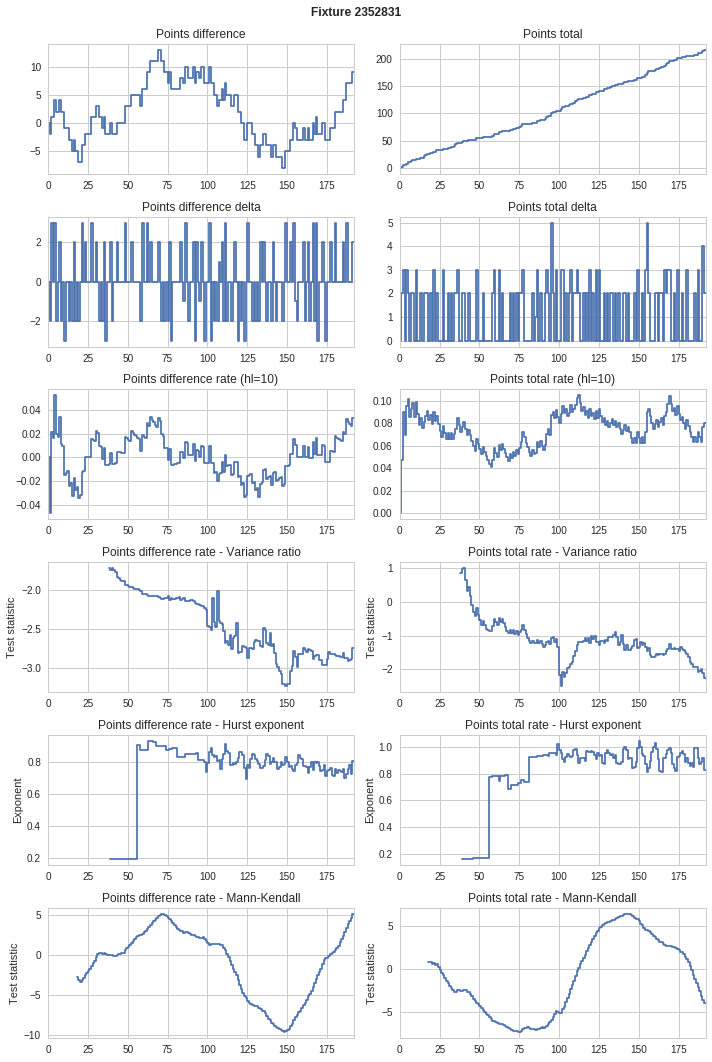

In [591]:
fixture_id = 2352831
pdf = df.loc[df.fixture_id == fixture_id, :]
fig, ax = P.subplots(6, 2, figsize=(10, 15))

ax[0, 0].step(pdf.interval, pdf.points_diff)
ax[0, 0].set_title('Points difference')
ax[0, 1].step(pdf.interval, pdf.points_tot)
ax[0, 1].set_title('Points total')

ax[1, 0].set_title('Points difference delta')
ax[1, 0].step(pdf.interval, pdf.points_delta_diff)
ax[1, 1].set_title('Points total delta')
ax[1, 1].step(pdf.interval, pdf.points_delta_tot)

ax[2, 0].set_title('Points difference rate (hl=10)')
ax[2, 0].step(pdf.interval, pdf.rate_diff)
ax[2, 1].set_title('Points total rate (hl=10)')
ax[2, 1].step(pdf.interval, pdf.rate_tot)

ax[3, 0].set_title('Points difference rate - Variance ratio')
ax[3, 0].step(pdf.interval, pdf.rate_diff_vr)
ax[3, 0].set_ylabel('Test statistic')
ax[3, 1].set_title('Points total rate - Variance ratio')
ax[3, 1].step(pdf.interval, pdf.rate_tot_vr)
ax[3, 1].set_ylabel('Test statistic')

ax[4, 0].set_title('Points difference rate - Hurst exponent')
ax[4, 0].step(pdf.interval, pdf.rate_diff_he)
ax[4, 0].set_ylabel('Exponent')
ax[4, 1].set_title('Points total rate - Hurst exponent')
ax[4, 1].step(pdf.interval, pdf.rate_tot_he)
ax[4, 1].set_ylabel('Exponent')

ax[5, 0].set_title('Points difference rate - Mann-Kendall')
ax[5, 0].step(pdf.interval, pdf.rate_diff_mk)
ax[5, 0].set_ylabel('Test statistic')
ax[5, 1].set_title('Points total rate - Mann-Kendall')
ax[5, 1].step(pdf.interval, pdf.rate_tot_mk)
ax[5, 1].set_ylabel('Test statistic')

for axi in np.ravel(ax):
    axi.set_xlim([0, pdf.interval.max()])

fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.suptitle('Fixture {}'.format(fixture_id), fontweight='bold')


In [328]:
sdf = df.loc[:, ['interval', 'rate_tot']].rename(columns={'rate_tot': 'close'})
sdf.loc[:, 'low'] = sdf.close
sdf.loc[:, 'high'] = sdf.close
s = StockDataFrame.retype(sdf, index_column='interval')
# s.get('macd')